# Importing the necessary libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle

In [4]:
books_df = pd.read_csv("Books.csv")
ratings_df = pd.read_csv("Ratings.csv")

C:\Users\atrih\AppData\Local\Temp\ipykernel_21668\106719867.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv("Books.csv")


In [5]:
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


# **Exploratory Data Analysis**

In [7]:
books_df.shape, ratings_df.shape

((271360, 8), (1149780, 3))

In [8]:
# duplicate rows
books_df.duplicated().sum(), ratings_df.duplicated().sum()

(0, 0)

In [9]:
# null values
books_df.isna().sum(), ratings_df.isna().sum()

(ISBN                   0
 Book-Title             0
 Book-Author            2
 Year-Of-Publication    0
 Publisher              2
 Image-URL-S            0
 Image-URL-M            0
 Image-URL-L            3
 dtype: int64,
 User-ID        0
 ISBN           0
 Book-Rating    0
 dtype: int64)

In [10]:
books_df.dropna(inplace=True)

In [11]:
books_df.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

In [12]:
# Top Authors
books_df['Book-Author'].value_counts()

Book-Author
Agatha Christie         632
William Shakespeare     567
Stephen King            524
Ann M. Martin           423
Carolyn Keene           373
                       ... 
R. Gelman                 1
Ellery R. Sheets          1
Artiste C. Arthur         1
Emily Pearl Kingsley      1
Christopher  Biffle       1
Name: count, Length: 102019, dtype: int64

In [13]:
# Top Publisher
books_df['Publisher'].value_counts()

Publisher
Harlequin                        7535
Silhouette                       4220
Pocket                           3905
Ballantine Books                 3783
Bantam Books                     3646
                                 ... 
Windstream Publishing Company       1
Polaris Books                       1
Hannover House                      1
Amber Quill Press, LLC.             1
Connaught                           1
Name: count, Length: 16803, dtype: int64

In [14]:
books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].apply(lambda x: int(x))

In [15]:
books_df['Year-Of-Publication'].value_counts().reset_index().sort_values(by = "Year-Of-Publication")

,Year-Of-Publication,count
21,0,4618
99,1376,1
100,1378,1
106,1806,1
102,1897,1
...,...,...
104,2026,1
73,2030,7
115,2037,1
110,2038,1


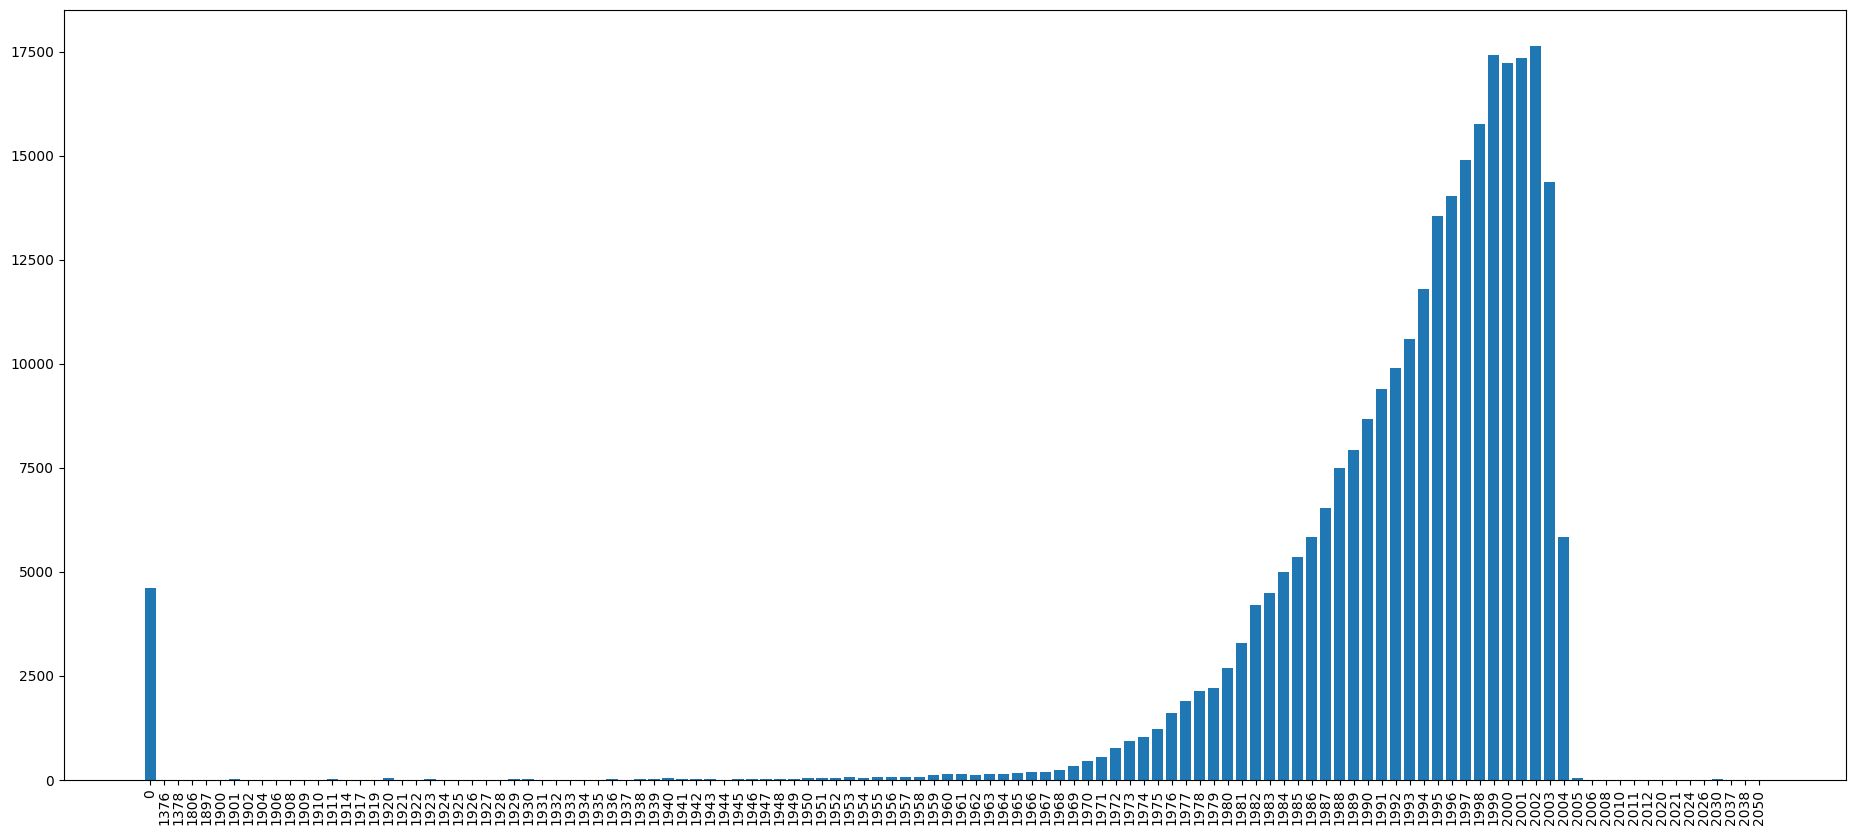

In [16]:
# Publication Year Distribution
plt.figure(figsize = (23, 10))
plt.bar(np.array(books_df['Year-Of-Publication'].value_counts().reset_index().sort_values(by = "Year-Of-Publication")['Year-Of-Publication'], dtype = np.str_), np.array(books_df['Year-Of-Publication'].value_counts().reset_index().sort_values(by = "Year-Of-Publication")['count']))
plt.xticks(rotation=90)
plt.show()

# **Model Building**

### **Popularity Based recommendation system**

In [17]:
books_rating_df = ratings_df.merge(books_df, on='ISBN')[['Book-Title', 'Book-Rating']]

In [18]:
books_rating_df.shape

(1031128, 2)

In [19]:
books_rating_df.head()

,Book-Title,Book-Rating
0,Flesh Tones: A Novel,0
1,Rites of Passage,5
2,The Notebook,0
3,Help!: Level 1,3
4,The Amsterdam Connection : Level 4 (Cambridge ...,6


In [20]:
rating_count_df = books_rating_df.groupby("Book-Title").count()["Book-Rating"].reset_index()
rating_count_df.rename(columns={'Book-Rating': 'rating_count'}, inplace=True)

In [21]:
rating_count_df.head()

,Book-Title,rating_count
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


In [22]:
rating_average_df = books_rating_df.groupby("Book-Title").mean()['Book-Rating'].reset_index()
rating_average_df.rename(columns={'Book-Rating': 'average_rating'}, inplace=True)

In [23]:
rating_average_df.head()

,Book-Title,average_rating
0,A Light in the Storm: The Civil War Diary of ...,2.25
1,Always Have Popsicles,0.00
2,Apple Magic (The Collector's series),0.00
3,"Ask Lily (Young Women of Faith: Lily Series, ...",8.00
4,Beyond IBM: Leadership Marketing and Finance ...,0.00


In [24]:
popular_book_df = rating_count_df.merge(rating_average_df, on='Book-Title')
popular_book_df.head()

,Book-Title,rating_count,average_rating
0,A Light in the Storm: The Civil War Diary of ...,4,2.25
1,Always Have Popsicles,1,0.00
2,Apple Magic (The Collector's series),1,0.00
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1,8.00
4,Beyond IBM: Leadership Marketing and Finance ...,1,0.00


In [25]:
popular_book_df = popular_book_df[popular_book_df['rating_count'] > 250].sort_values(by = ['average_rating'], ascending=False).iloc[0:50].reset_index().drop(['index'], axis=1)

In [26]:
popular_book_df.shape

(50, 3)

In [27]:
popular_book_df.head()

,Book-Title,rating_count,average_rating
0,Harry Potter and the Prisoner of Azkaban (Book 3),428,5.852804
1,Harry Potter and the Goblet of Fire (Book 4),387,5.824289
2,Harry Potter and the Sorcerer's Stone (Book 1),278,5.737410
3,Harry Potter and the Order of the Phoenix (Boo...,347,5.501441
4,Harry Potter and the Chamber of Secrets (Book 2),556,5.183453


In [28]:
popular_book_df = popular_book_df.merge(books_df, on='Book-Title')

In [29]:
popular_book_df.shape

(196, 10)

In [30]:
popular_book_df.columns

Index(['Book-Title', 'rating_count', 'average_rating', 'ISBN', 'Book-Author',
       'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M',
       'Image-URL-L'],
      dtype='object')

In [31]:
popular_book_df = popular_book_df.drop_duplicates(['Book-Title'])[['Book-Title', 'Book-Author', 'Year-Of-Publication', 'rating_count', 'average_rating', 'Image-URL-M']]

In [32]:
popular_book_df.shape

(50, 6)

In [33]:
popular_book_df.head()

,Book-Title,Book-Author,Year-Of-Publication,rating_count,average_rating,Image-URL-M
0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,428,5.852804,http://images.amazon.com/images/P/0439136350.0...
3,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,387,5.824289,http://images.amazon.com/images/P/0439139597.0...
5,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,1998,278,5.737410,http://images.amazon.com/images/P/0590353403.0...
9,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,347,5.501441,http://images.amazon.com/images/P/043935806X.0...
13,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,556,5.183453,http://images.amazon.com/images/P/0439064872.0...


## saving the model

In [34]:
pickle.dump(popular_book_df, open('popular_books.pkl', 'wb'))

### **Collaborative Filtering based Recommendor system**

In [35]:
filtered_user_ratings = ratings_df.groupby("User-ID").count()

In [36]:
filtered_user_ratings.shape

(105283, 2)

In [37]:
filtered_user_ratings = filtered_user_ratings[filtered_user_ratings['Book-Rating'] > 200]

In [38]:
filtered_user_ratings.shape

(899, 2)

In [39]:
filtered_user_ratings.head()

,ISBN,Book-Rating
User-ID,,
254,314,314
2276,498,498
2766,274,274
2977,232,232
3363,901,901


In [40]:
filtered_books_rating = ratings_df[ratings_df['User-ID'].isin(filtered_user_ratings.index)]

In [41]:
filtered_books_rating.shape

(526356, 3)

In [42]:
x = filtered_books_rating.groupby("ISBN").count()

In [43]:
x.shape

(207291, 2)

In [44]:
x = x[x['Book-Rating'] >= 50]

In [45]:
x.shape

(525, 2)

In [46]:
x.head(1)

,User-ID,Book-Rating
ISBN,,
002542730X,80,80


In [47]:
filtered_books_rating.head(1)

,User-ID,ISBN,Book-Rating
1456,277427,002542730X,10


In [48]:
filtered_books_rating = filtered_books_rating[filtered_books_rating['ISBN'].isin(x.index)]

In [49]:
filtered_books_rating.shape

(41986, 3)

In [50]:
filtered_rating = filtered_books_rating.merge(books_df, on='ISBN')

In [51]:
filtered_rating = filtered_rating[['User-ID', 'ISBN', 'Book-Rating', 'Book-Title', 'Book-Author', 'Image-URL-M']]

In [52]:
filtered_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Image-URL-M
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,http://images.amazon.com/images/P/002542730X.0...
1,277427,0060930535,0,The Poisonwood Bible: A Novel,Barbara Kingsolver,http://images.amazon.com/images/P/0060930535.0...
2,277427,0060934417,0,Bel Canto: A Novel,Ann Patchett,http://images.amazon.com/images/P/0060934417.0...
3,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,http://images.amazon.com/images/P/0061009059.0...
4,277427,0140067477,0,The Tao of Pooh,Benjamin Hoff,http://images.amazon.com/images/P/0140067477.0...


In [53]:
pt = filtered_rating.pivot_table(index='Book-Title', columns = 'User-ID', values = 'Book-Rating')

In [54]:
pt = pt.fillna(0)

In [55]:
pt

User-ID,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
similar_books = cosine_similarity(pt)

In [57]:
similar_books.shape

(514, 514)

In [58]:
similar_books

array([[1.        , 0.06846072, 0.        , ..., 0.10612371, 0.        ,
        0.        ],
       [0.06846072, 1.        , 0.28189436, ..., 0.04456303, 0.13388717,
        0.19980671],
       [0.        , 0.28189436, 1.        , ..., 0.05037976, 0.07063616,
        0.0985358 ],
       ...,
       [0.10612371, 0.04456303, 0.05037976, ..., 1.        , 0.07467569,
        0.04902157],
       [0.        , 0.13388717, 0.07063616, ..., 0.07467569, 1.        ,
        0.16972567],
       [0.        , 0.19980671, 0.0985358 , ..., 0.04902157, 0.16972567,
        1.        ]])

In [59]:
pt = pt.reset_index()

In [73]:
def top_4_similar_books(bookname):

  if(len(pt[pt['Book-Title'].str.contains(bookname, case=False, na=False)].index) == 0):
    return
  ind = pt[pt['Book-Title'].str.contains(bookname, case=False, na=False)].index[0]
  similar_items = similar_books[ind]
  top_4 = sorted(list(enumerate(similar_items)), key = lambda x: x[1], reverse=True)[1:5]
  book_info = []
  for i, j in top_4:
    
    book_name = pt[pt.index == i]['Book-Title'].values[0]
    author = books_df[books_df['Book-Title'] == book_name].iloc[0]['Book-Author']
    year = books_df[books_df['Book-Title'] == book_name].iloc[0]['Year-Of-Publication']
    img_url = books_df[books_df['Book-Title'] == book_name].iloc[0]['Image-URL-M']
    book_info.append([book_name, author, year, img_url])
    
  return book_info


In [76]:
top_4_similar_books("Year of Wonders")

[['A Heartbreaking Work of Staggering Genius',
  'Dave Eggers',
  2001,
  'http://images.amazon.com/images/P/0375725784.01.MZZZZZZZ.jpg'],
 ['Empire Falls',
  'Richard Russo',
  2002,
  'http://images.amazon.com/images/P/0375726403.01.MZZZZZZZ.jpg'],
 ['The God of Small Things',
  'Arundhati Roy',
  1998,
  'http://images.amazon.com/images/P/0060977493.01.MZZZZZZZ.jpg'],
 ['A Civil Action',
  'JONATHAN HARR',
  1996,
  'http://images.amazon.com/images/P/0679772677.01.MZZZZZZZ.jpg']]

In [78]:
top_4_similar_books("1984") # exact book name

[["The Handmaid's Tale",
  'Margaret Atwood',
  1989,
  'http://images.amazon.com/images/P/0449212602.01.MZZZZZZZ.jpg'],
 ['The Catcher in the Rye',
  'J.D. Salinger',
  1991,
  'http://images.amazon.com/images/P/0316769487.01.MZZZZZZZ.jpg'],
 ["Slaughterhouse Five or the Children's Crusade: A Duty Dance With Death",
  'Kurt Vonnegut',
  1991,
  'http://images.amazon.com/images/P/0440180295.01.MZZZZZZZ.jpg'],
 ['The Vampire Lestat (Vampire Chronicles, Book II)',
  'ANNE RICE',
  1986,
  'http://images.amazon.com/images/P/0345313860.01.MZZZZZZZ.jpg']]

In [79]:
top_4_similar_books("harry potter") # not the exact book name but related to it.

[['Harry Potter and the Prisoner of Azkaban (Book 3)',
  'J. K. Rowling',
  1999,
  'http://images.amazon.com/images/P/0439136350.01.MZZZZZZZ.jpg'],
 ['Harry Potter and the Goblet of Fire (Book 4)',
  'J. K. Rowling',
  2000,
  'http://images.amazon.com/images/P/0439139597.01.MZZZZZZZ.jpg'],
 ["Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
  'J. K. Rowling',
  1999,
  'http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg'],
 ['Harry Potter and the Order of the Phoenix (Book 5)',
  'J. K. Rowling',
  2003,
  'http://images.amazon.com/images/P/043935806X.01.MZZZZZZZ.jpg']]

In [80]:
top_4_similar_books("lord of the ring") # not the exact book name but related to it.

[['The Return of the King (The Lord of the Rings, Part 3)',
  'J.R.R. TOLKIEN',
  1986,
  'http://images.amazon.com/images/P/0345339738.01.MZZZZZZZ.jpg'],
 ['Night Whispers',
  'Judith McNaught',
  1999,
  'http://images.amazon.com/images/P/0671525743.01.MZZZZZZZ.jpg'],
 ['The Tale of the Body Thief (Vampire Chronicles (Paperback))',
  'Anne Rice',
  1993,
  'http://images.amazon.com/images/P/034538475X.01.MZZZZZZZ.jpg'],
 ['Fahrenheit 451',
  'Ray Bradbury',
  1994,
  'http://images.amazon.com/images/P/3257208626.01.MZZZZZZZ.jpg']]

In [81]:
top_4_similar_books("Night Whispers") # exact book name

[['Riptide',
  'Catherine Coulter',
  2001,
  'http://images.amazon.com/images/P/0515130966.01.MZZZZZZZ.jpg'],
 ['Portrait in Death',
  'Nora Roberts',
  2003,
  'http://images.amazon.com/images/P/0425189031.01.MZZZZZZZ.jpg'],
 ['Key of Valor (Roberts, Nora. Key Trilogy, 3.)',
  'Nora Roberts',
  2003,
  'http://images.amazon.com/images/P/0515136530.01.MZZZZZZZ.jpg'],
 ['Macgregor Brides (Macgregors)',
  'Nora Roberts',
  1997,
  'http://images.amazon.com/images/P/0373483503.01.MZZZZZZZ.jpg']]

In [82]:
top_4_similar_books("mahabharat") # no error on unknown book input

## saving the model related files

In [83]:
pickle.dump(books_df, open('books.pkl', 'wb'))
pickle.dump(pt, open('pt.pkl', 'wb'))
pickle.dump(similar_books, open('similar_books.pkl', 'wb'))